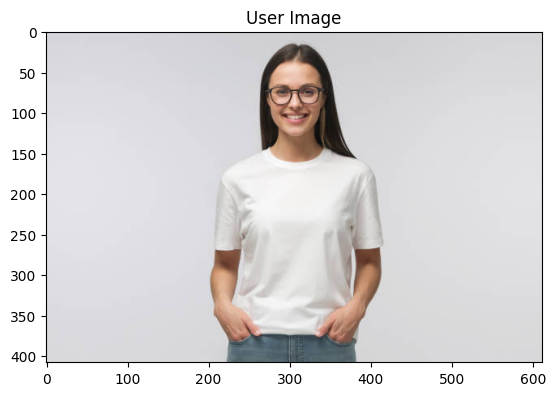

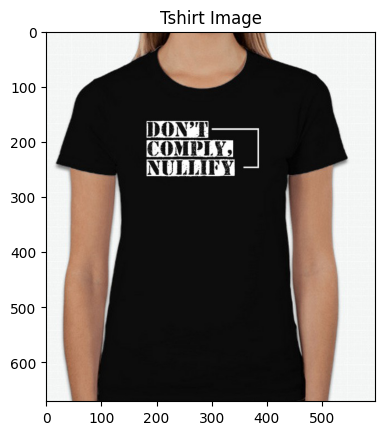

In [4]:
# Step 1: Load and Preprocess Images
import cv2 as cv
import numpy as np

# Load images
user_image = cv.imread('user.jpg')
tshirt_image = cv.imread('tshirt.png', cv.IMREAD_UNCHANGED)

# Ensure t-shirt image has 4 channels (RGBA)
if tshirt_image.shape[2] == 3:
    tshirt_image = cv.cvtColor(tshirt_image, cv.COLOR_RGB2RGBA)

# Convert t-shirt image to 3 channels for pose estimation
tshirt_rgb = cv.cvtColor(tshirt_image, cv.COLOR_BGRA2BGR)

# Display the images to check if they are loaded correctly
import matplotlib.pyplot as plt

plt.imshow(cv.cvtColor(user_image, cv.COLOR_BGR2RGB))
plt.title("User Image")
plt.show()

plt.imshow(cv.cvtColor(tshirt_image, cv.COLOR_BGR2RGB))
plt.title("Tshirt Image")
plt.show()




In [5]:
# Step 2: Perform Pose Estimation
# Load the pre-trained pose estimation model
net = cv.dnn.readNetFromTensorflow("graph_opt.pb")

# Function to perform pose estimation and extract keypoints
def pose_estimation(image, net, inWidth, inHeight, threshold):
    frameWidth = image.shape[1]
    frameHeight = image.shape[0]

    net.setInput(cv.dnn.blobFromImage(image, 1.0, (inWidth, inHeight), (127.5, 127.5, 127.5), swapRB=True, crop=False))
    out = net.forward()
    out = out[:, :19, :, :]  # MobileNet output [1, 57, -1, -1], we only need the first 19 elements

    BODY_PARTS = { "Nose": 0, "Neck": 1, "RShoulder": 2, "RElbow": 3, "RWrist": 4,
                   "LShoulder": 5, "LElbow": 6, "LWrist": 7, "RHip": 8, "RKnee": 9,
                   "RAnkle": 10, "LHip": 11, "LKnee": 12, "LAnkle": 13, "REye": 14,
                   "LEye": 15, "REar": 16, "LEar": 17, "Background": 18 }

    points = []
    for i in range(len(BODY_PARTS)):
        heatMap = out[0, i, :, :]
        _, conf, _, point = cv.minMaxLoc(heatMap)
        x = (frameWidth * point[0]) / out.shape[3]
        y = (frameHeight * point[1]) / out.shape[2]
        points.append((int(x), int(y)) if conf > threshold else None)

    return points

# Perform pose estimation
inWidth = 368
inHeight = 368
threshold = 0.2

user_keypoints = pose_estimation(user_image, net, inWidth, inHeight, threshold)
tshirt_keypoints = pose_estimation(tshirt_rgb, net, inWidth, inHeight, threshold)

# Print keypoints to verify
print("User Keypoints:", user_keypoints)
print("T-Shirt Keypoints:", tshirt_keypoints)


User Keypoints: [(306, 79), (306, 168), (239, 177), (212, 283), (212, 328), (372, 177), (399, 266), None, (266, 372), (212, 337), (239, 372), (332, 363), None, None, (279, 70), (319, 70), (266, 88), (345, 79), (585, 381)]
T-Shirt Keypoints: [None, None, (91, 116), None, None, (468, 116), None, None, None, None, None, None, None, None, None, None, None, None, (0, 627)]


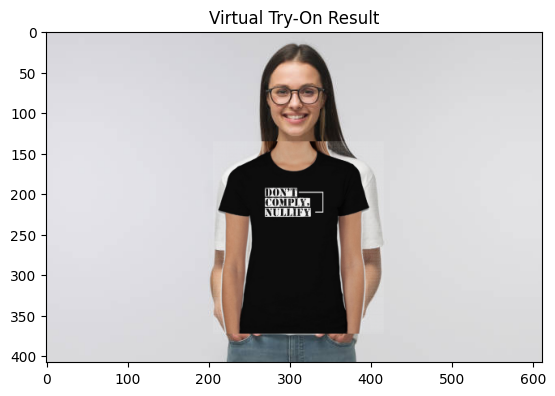

In [6]:
# Step 3: Resize and Overlay T-Shirt
# Extract shoulder keypoints
left_shoulder_user = user_keypoints[5]
right_shoulder_user = user_keypoints[2]

left_shoulder_tshirt = tshirt_keypoints[5]
right_shoulder_tshirt = tshirt_keypoints[2]

# Calculate distance between shoulders
if left_shoulder_user and right_shoulder_user and left_shoulder_tshirt and right_shoulder_tshirt:
    user_shoulder_width = np.linalg.norm(np.array(left_shoulder_user) - np.array(right_shoulder_user))
    tshirt_shoulder_width = np.linalg.norm(np.array(left_shoulder_tshirt) - np.array(right_shoulder_tshirt))

    # Resize t-shirt to match user's shoulder width
    scale_factor = user_shoulder_width / tshirt_shoulder_width
    tshirt_resized = cv.resize(tshirt_image, None, fx=scale_factor, fy=scale_factor, interpolation=cv.INTER_AREA)

    # Get position to overlay t-shirt on user
    x_offset = int(left_shoulder_user[0] - left_shoulder_tshirt[0] * scale_factor)
    y_offset = int(left_shoulder_user[1] - left_shoulder_tshirt[1] * scale_factor)

    # Ensure the offsets are within the image bounds
    x_offset = max(0, x_offset)
    y_offset = max(0, y_offset)

    # Extract the alpha channel from the t-shirt image
    tshirt_rgb = tshirt_resized[:, :, :3]
    tshirt_alpha = tshirt_resized[:, :, 3] / 255.0

    # Define ROI on the user image
    roi = user_image[y_offset:y_offset + tshirt_rgb.shape[0], x_offset:x_offset + tshirt_rgb.shape[1]]

    # Ensure ROI is within bounds
    roi_height, roi_width = roi.shape[:2]
    tshirt_height, tshirt_width = tshirt_rgb.shape[:2]

    if roi_height < tshirt_height or roi_width < tshirt_width:
        print("ROI is smaller than the resized t-shirt image.")
    else:
        # Blend t-shirt with user image
        for c in range(0, 3):
            roi[:, :, c] = (1 - tshirt_alpha) * roi[:, :, c] + tshirt_alpha * tshirt_rgb[:, :, c]

        # Put the blended image back into the user image
        user_image[y_offset:y_offset + tshirt_rgb.shape[0], x_offset:x_offset + tshirt_rgb.shape[1]] = roi

        # Save and display the result
        cv.imwrite('result_image.png', user_image)
        plt.imshow(cv.cvtColor(user_image, cv.COLOR_BGR2RGB))
        plt.title("Virtual Try-On Result")
        plt.show()
else:
    print("Failed to detect shoulders in either the user or t-shirt image.")
